# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


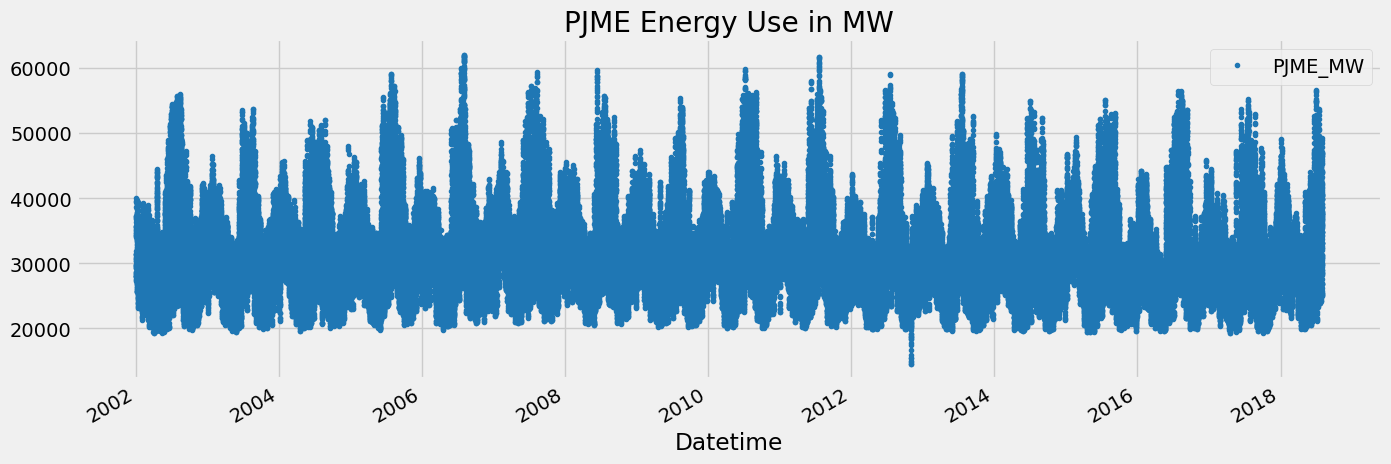

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

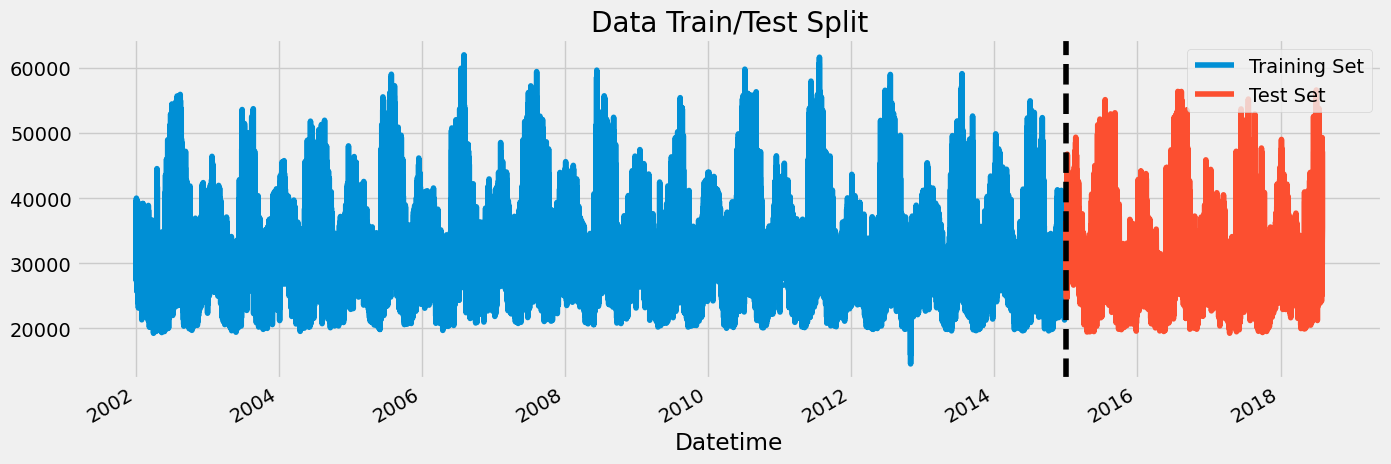

In [24]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

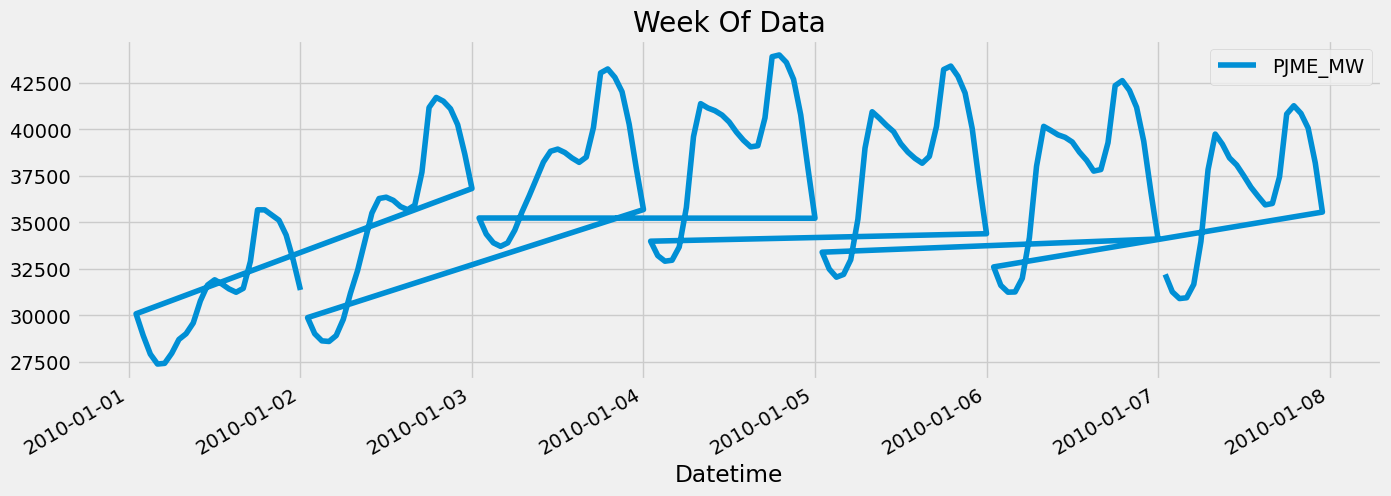

In [25]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [27]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

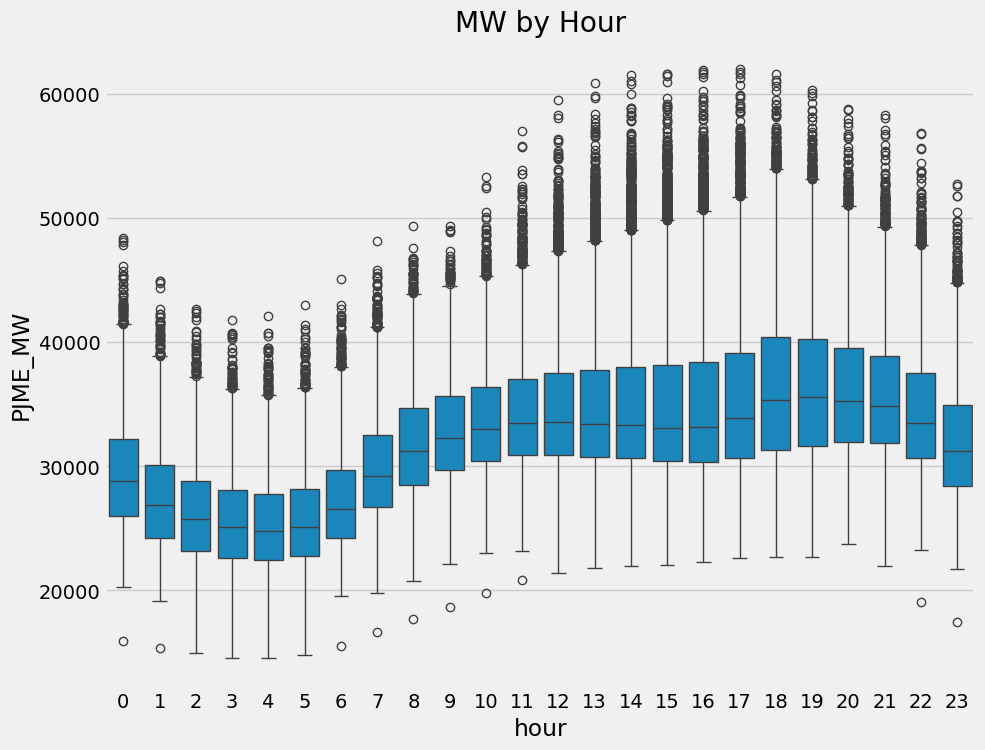

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_10640\2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


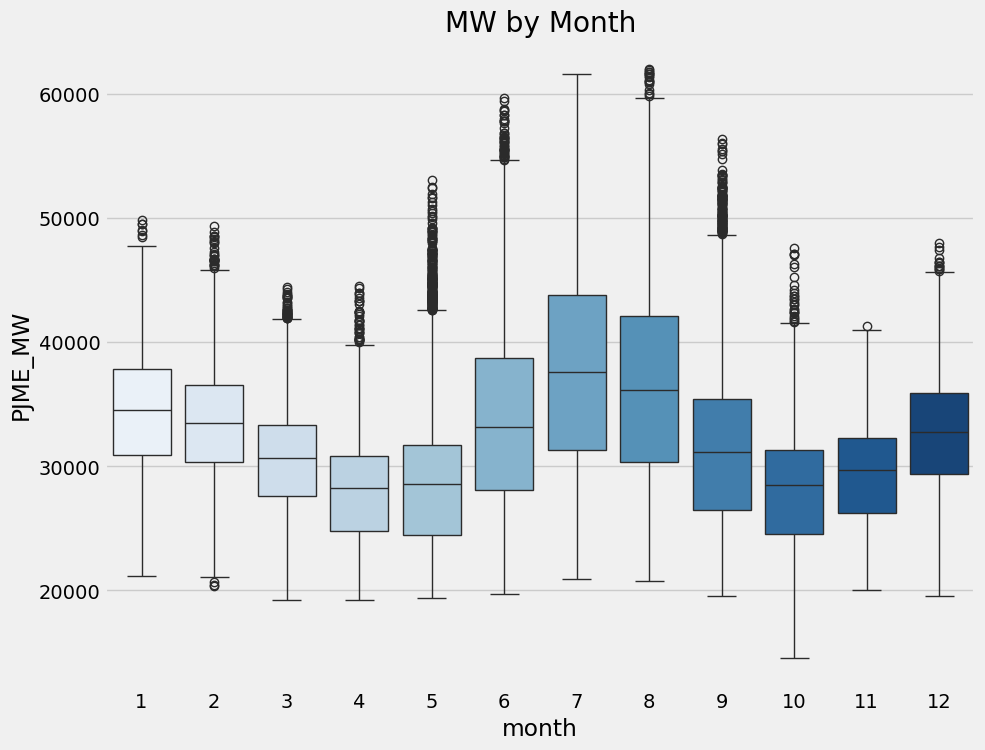

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [32]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['PJME_MW'].values)
result

(-18.8289127290842,
 2.022124508152674e-30,
 74,
 145291,
 {'1%': -3.430395009088914,
  '5%': -2.861559893380481,
  '10%': -2.5667805885384065},
 2296512.8411437003)

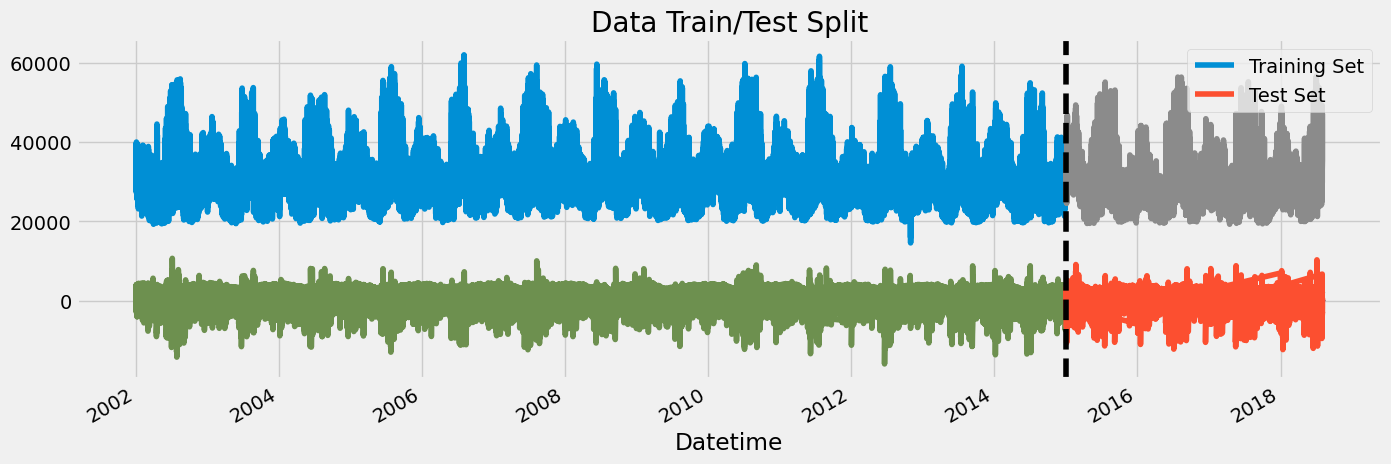

In [46]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Create our Model

In [12]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


F:\SOFTWARE\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

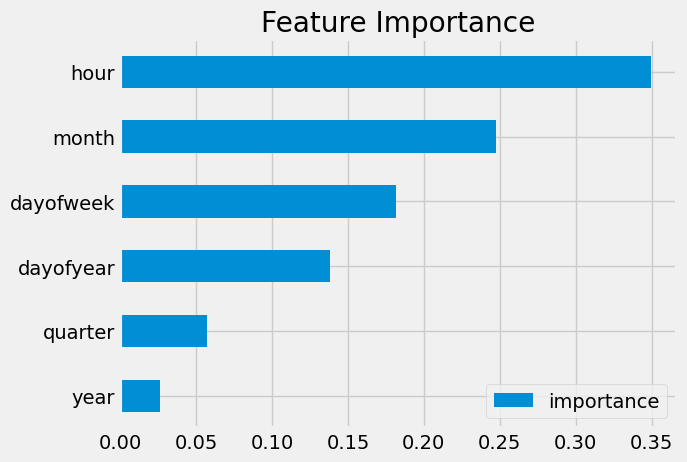

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

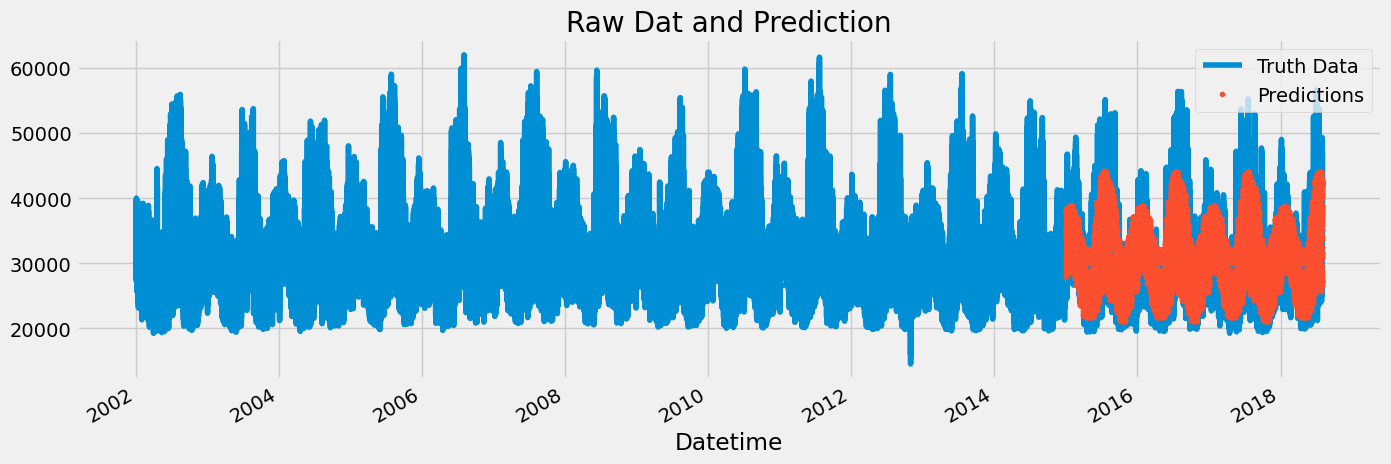

In [15]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

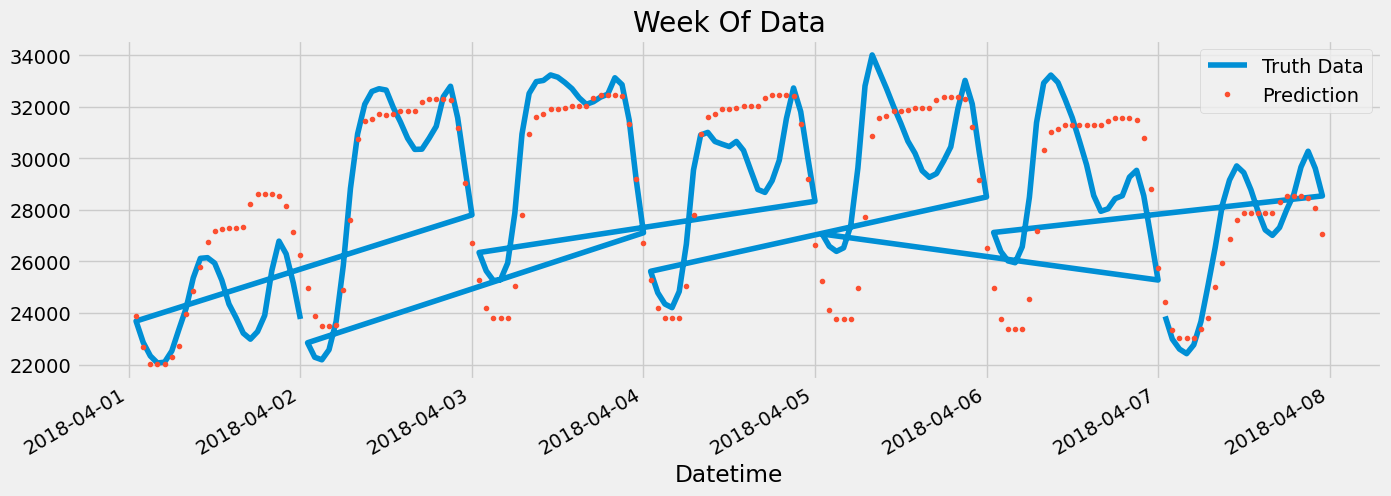

In [16]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [17]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


# Calculate Error
- Look at the worst and best predicted days

In [18]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

In [ ]:
# Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

# Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

# Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

# If the null hypothesis can be rejected, we can conclude that the time series is stationary.

# There are two ways to rejects the null hypothesis:

# On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

# **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
# On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

# **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [48]:
df.head(3)


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,depth_to_groundwater_diff_1
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,0.0
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,-1351.0
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,-573.0


In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [51]:
decomp = seasonal_decompose(df['PJME_MW'], period=52, model='additive', extrapolate_trend='freq')

In [54]:
df['trend'] = decomp.trend
df['seasonal'] = decomp.seasonal

In [61]:
df.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,depth_to_groundwater_diff_1,trend,seasonal
Datetime,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,0.0,30815.972856,1.359691
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,-1351.0,30807.999784,8.531122


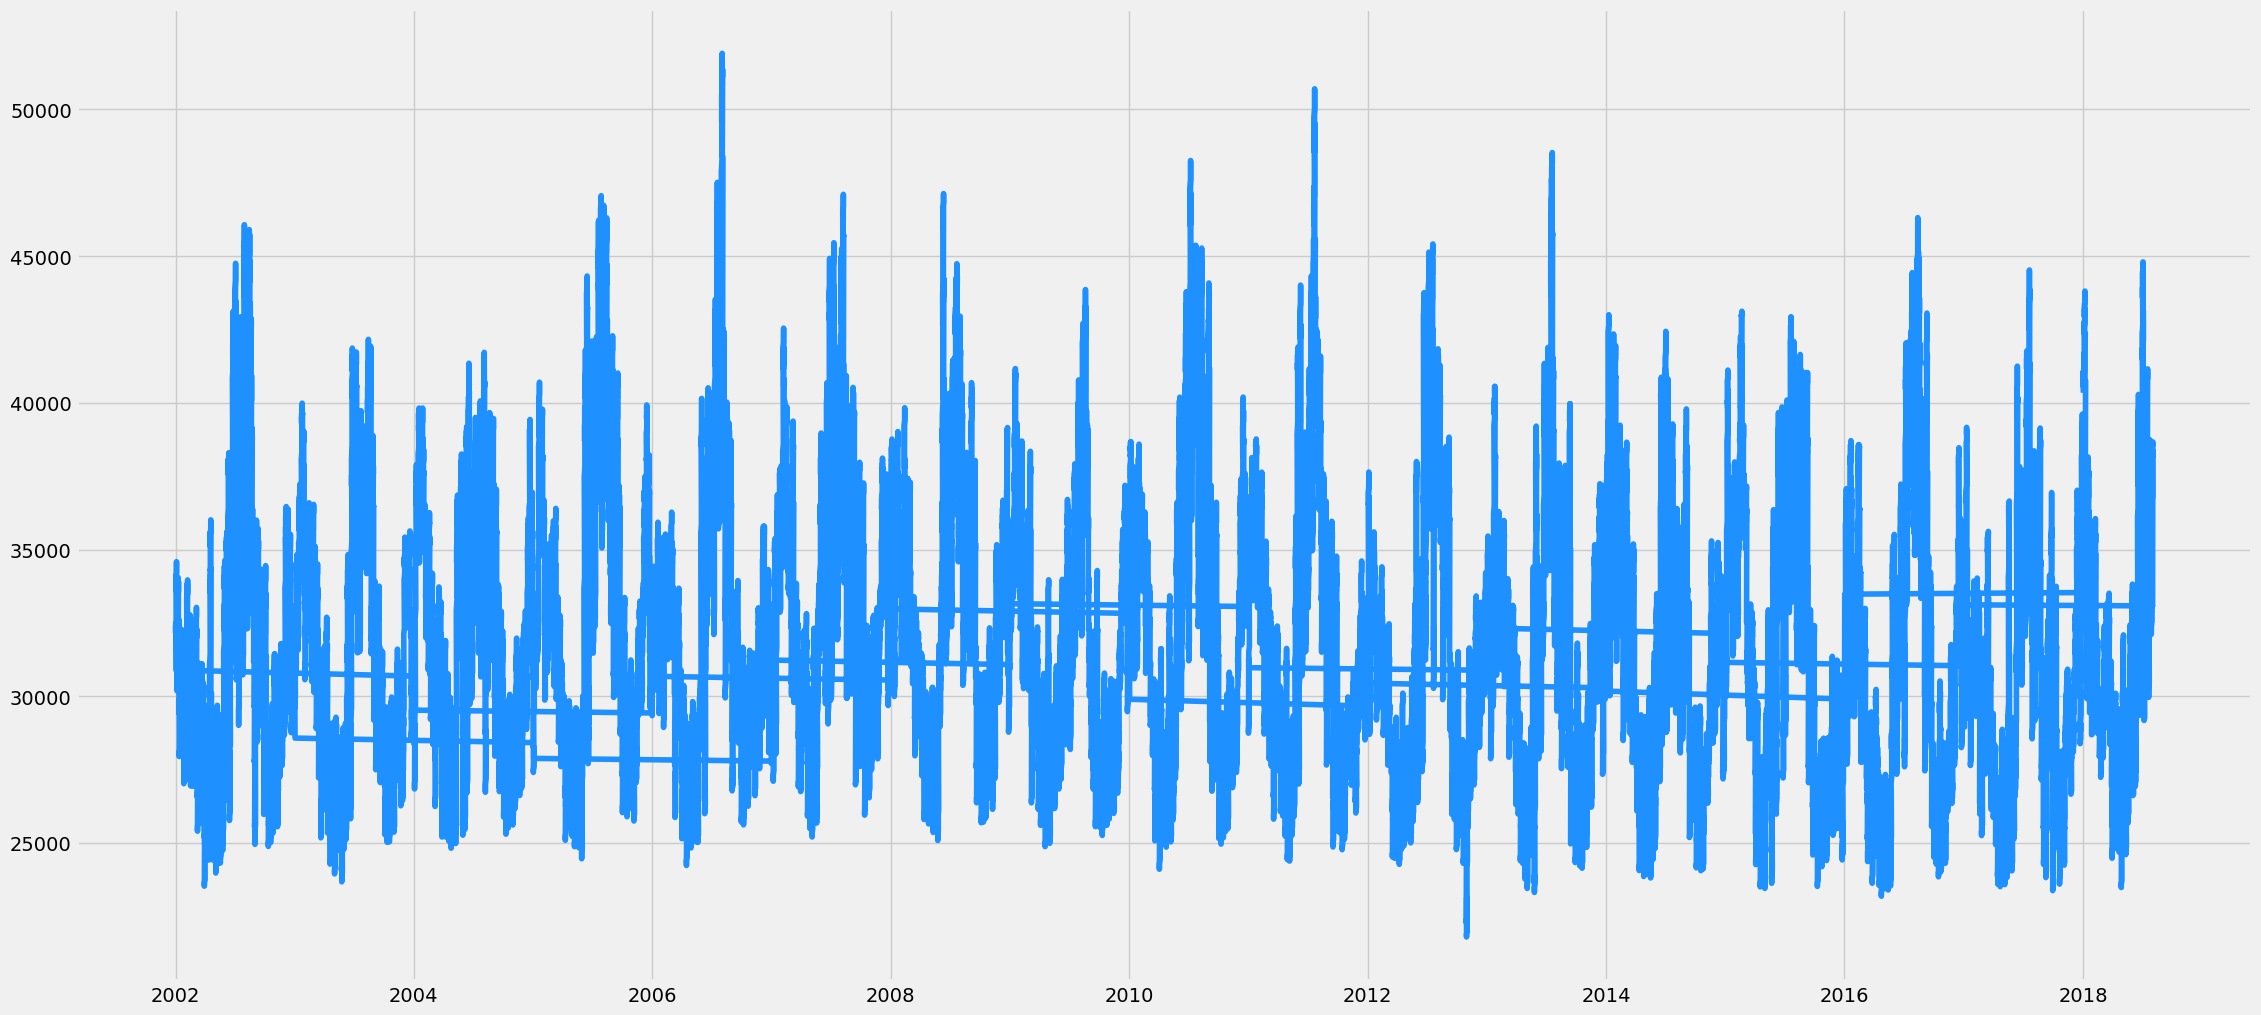

In [60]:
plt.figure(figsize=(25,12))
plt.plot(df['trend'], color='dodgerblue')

#  Autocorrelation Analysis

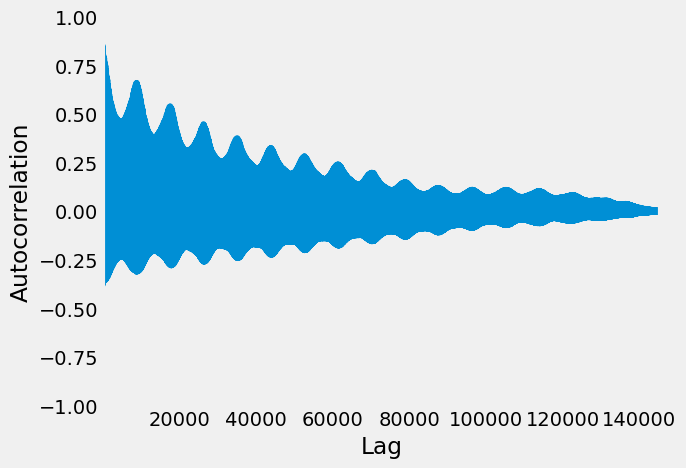

In [64]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

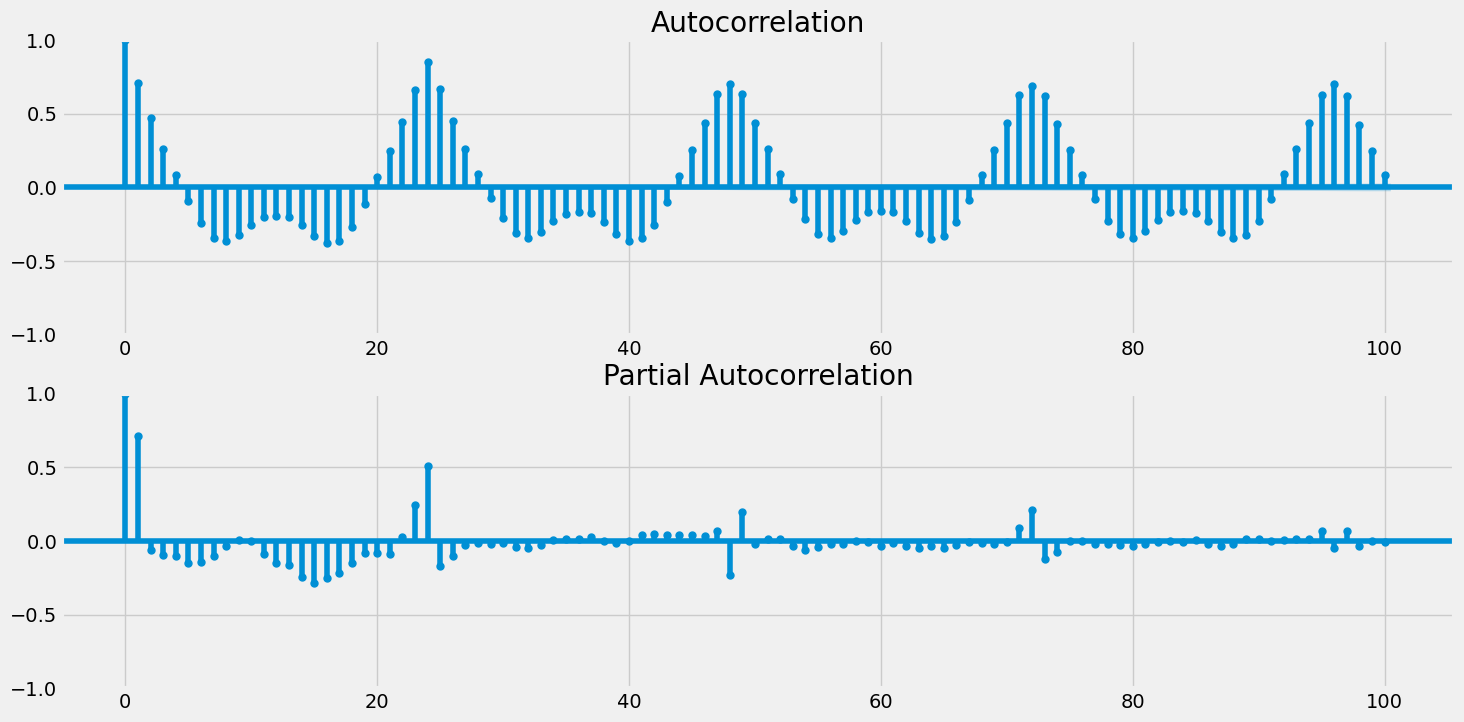

In [73]:
f, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

In [77]:
df1 = df.reset_index()

In [116]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df1[['Datetime', 'PJME_MW']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))


123561 21805


In [121]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(steps=test_size)

# Ensure that y_pred and y_valid have the same length for error metrics
if len(y_pred) == len(y_valid):
    score_mae = mean_absolute_error(y_valid, y_pred)
    score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

    print(f'RMSE: {score_rmse}')
else:
    print("Length mismatch between predictions and actual values")

RMSE: 6795.5567716587275


In [124]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2111874.566, Time=22.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2920888.052, Time=1.50 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=2.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2753567.519, Time=29.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2082920.431, Time=11.96 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.85 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2065880.199, Time=82.70 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=3.51 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2082594.644, Time=84.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2082306.598, Time=16.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2071953.701, Time=80.34 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 339.020 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:

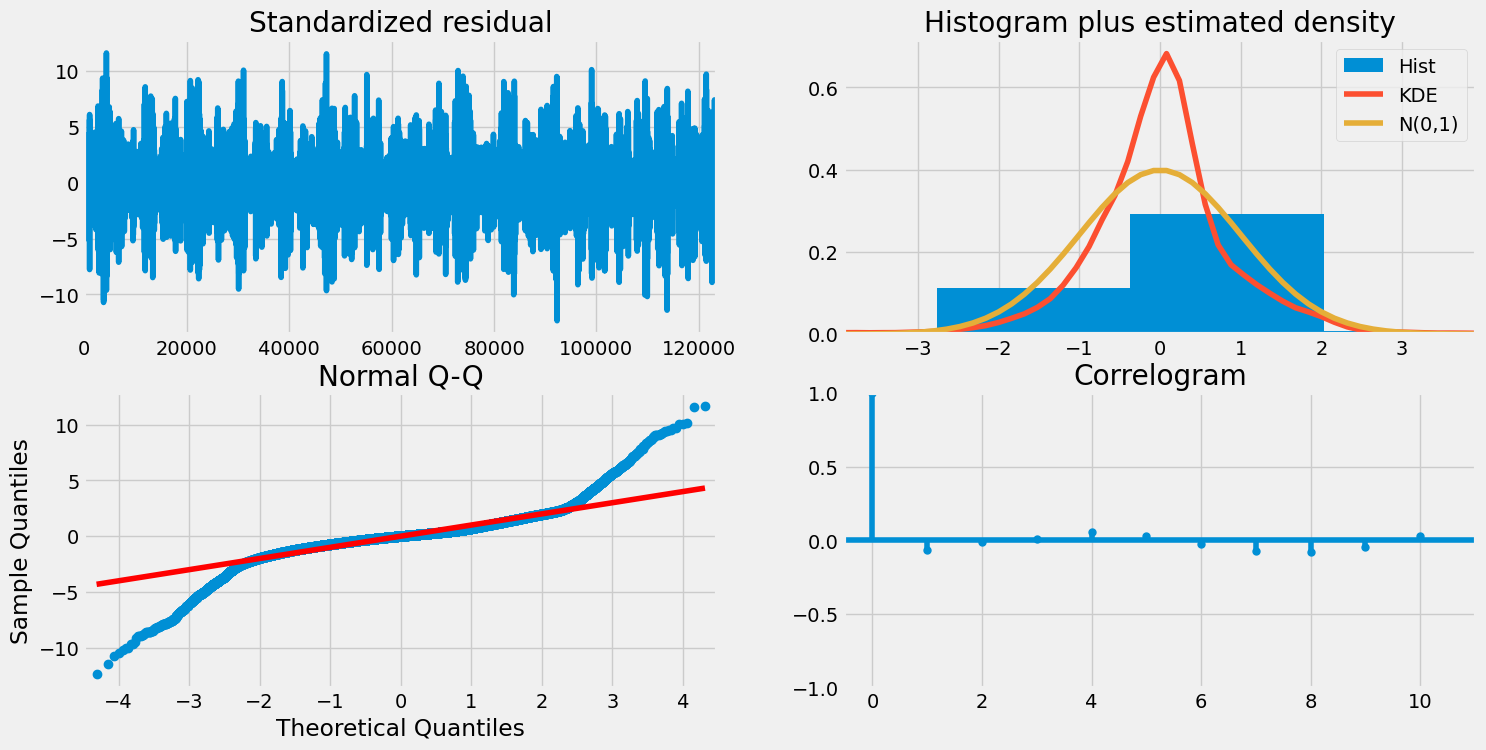

In [125]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [126]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.74815127],
       [-0.77661435],
       [-0.7886864 ],
       [-0.79249974],
       [-0.78266091],
       [-0.75396608],
       [-0.70171705],
       [-0.65966502],
       [-0.63644791],
       [-0.62467081]])

In [127]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

123457 21805


In [129]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

F:\SOFTWARE\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
123457/123457 ━━━━━━━━━━━━━━━━━━━━ 434s 3ms/step - loss: 0.0014 - val_loss: 3.2779e-04
Epoch 2/5
123457/123457 ━━━━━━━━━━━━━━━━━━━━ 399s 3ms/step - loss: 4.1611e-04 - val_loss: 2.7233e-04
Epoch 3/5
123457/123457 ━━━━━━━━━━━━━━━━━━━━ 1560s 13ms/step - loss: 3.4216e-04 - val_loss: 2.7660e-04
Epoch 4/5
123457/123457 ━━━━━━━━━━━━━━━━━━━━ 488s 4ms/step - loss: 3.1731e-04 - val_loss: 2.4010e-04
Epoch 5/5
123457/123457 ━━━━━━━━━━━━━━━━━━━━ 420s 3ms/step - loss: 2.8458e-04 - val_loss: 2.1976e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          92,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

In [131]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(score_rmse)

3859/3859 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [1]:
def fibonacci(n):
    fib_series = [0, 1]
    while len(fib_series) < n:
        fib_series.append(fib_series[-1] + fib_series[-2])
    return fib_series

n = 10 
fib_series = fibonacci(n)
print(fib_series)

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]


In [4]:
def fibbonaci(n):
    if n <= 0:
        return []
    elif n ==1:
        return [0]
    elif n==2:
        return [0,1]
    fib_serie = [0,1]
    for i in range(2,n):
        row = fib_serie[-1] + fib_serie[-2]
        fib_serie.append(row)
    return fib_serie
fibbonaci(10)

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

# hi